In [1]:
import inspect
import os
import sys

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

import cv2
import h5py
import numpy as np
from src.detection.training import get_dataloaders

import matplotlib.pyplot as plt
from numba import njit


In [ ]:
with h5py.File('../data/dataset_thin_edges.h5') as hf:
    images = hf['training/images'][:]
    masks = hf['training/masks'][:]
images.mean(), images.std()

In [22]:
train_loader, validation_loader, test_loader = get_dataloaders("../data/dataset_thin_edges.h5")

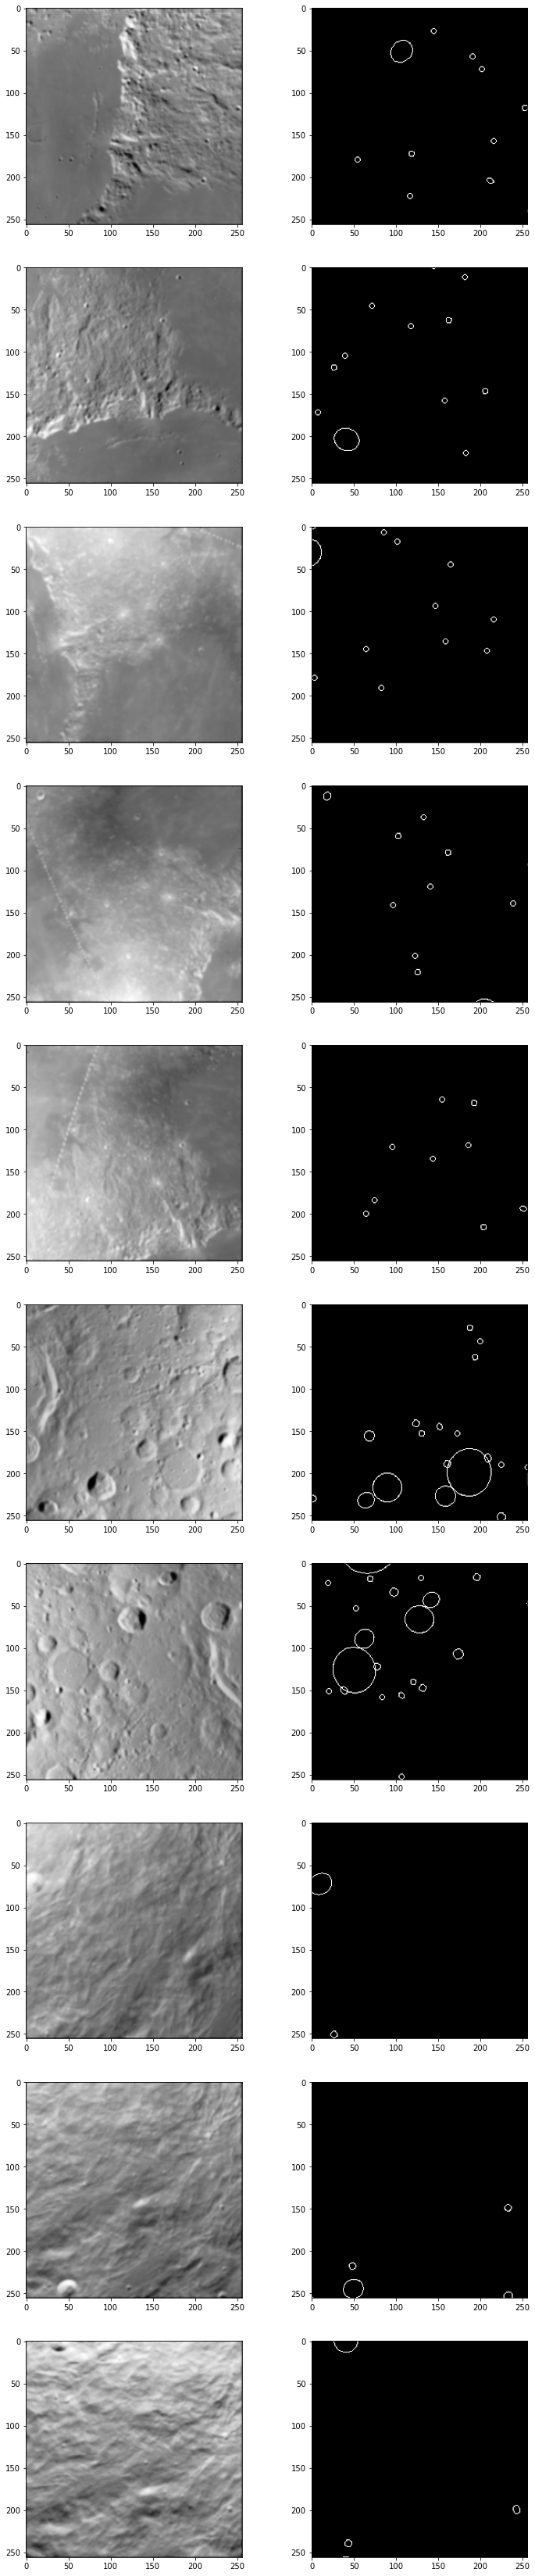

In [17]:
n_images = 10
fig, axes = plt.subplots(n_images, 2, figsize=(12, 60))

for i in range(n_images):
    axes[i, 0].imshow(images[i][0], cmap='Greys_r')
    axes[i, 1].imshow(masks[i][0], cmap='Greys_r')

IndexError: index 0 is out of bounds for dimension 0 with size 0

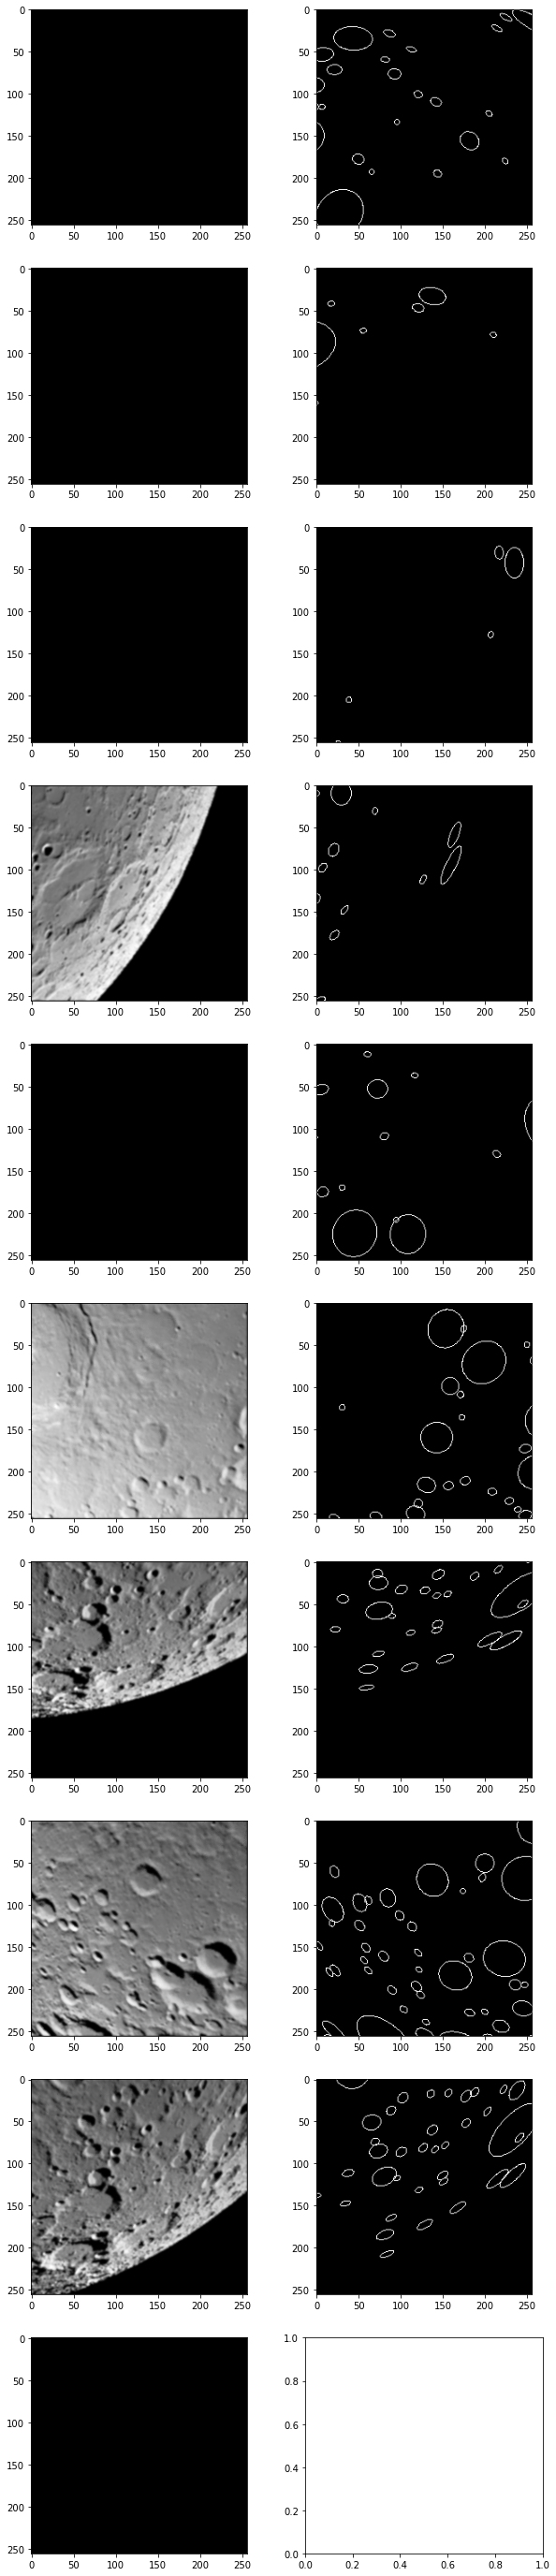

In [30]:
images2, targets = next(iter(test_loader))
fig, axes = plt.subplots(len(images2), 2, figsize=(10, 50))

for i in range(len(images2)):
    axes[i, 0].imshow(images2[i][0].numpy(), cmap='Greys_r')
    axes[i, 1].imshow((targets[i]["masks"][0] > 0).numpy().astype(float), cmap='gray')

({'boxes': tensor([[218.,  99., 230., 125.]]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.int32),
  'image_id': tensor([4554]),
  'area': tensor([312.]),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[ 74.,   0., 255., 186.]]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.int32),
  'image_id': tensor([9231]),
  'area': tensor([33666.]),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[  3.,   0., 252., 151.]]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0,

In [ ]:
n_images = 12
fig, axes = plt.subplots(n_images, 4, figsize=(20, 60))

clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))

pixel_range = (0, 256)

for i in range(n_images):

    test_img = images[i].squeeze()
    axes[i, 0].imshow(test_img, cmap='Greys_r')

    hist, bins = np.histogram(test_img.flatten(), 256, pixel_range)
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()
    axes[i, 1].plot(cdf_normalized, color = 'b')
    axes[i, 1].hist(test_img.flatten(), 256, pixel_range, color = 'r')
    axes[i, 1].set_xlim(pixel_range)
    axes[i, 1].legend(('cdf','histogram'), loc = 'upper left')

    clahe_img = clahe.apply(test_img.astype(np.uint8))
    axes[i, 2].imshow(clahe_img, cmap='Greys_r')

    hist, bins = np.histogram(clahe_img.flatten(), 256, pixel_range)
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()
    axes[i, 3].plot(cdf_normalized, color = 'b')
    axes[i, 3].hist(clahe_img.flatten(), 256, pixel_range, color = 'r')
    axes[i, 3].set_xlim(pixel_range)
    axes[i, 3].legend(('cdf','histogram'), loc = 'upper left')

In [12]:
# https://automaticaddison.com/how-to-do-histogram-matching-using-opencv/

def calculate_cdf(histogram: np.ndarray):
    """
    This method calculates the cumulative distribution function
    :param array histogram: The values of the histogram
    :return: normalized_cdf: The normalized cumulative distribution function
    :rtype: array
    """
    # Get the cumulative sum of the elements
    cdf = histogram.cumsum()

    # Normalize the cdf
    normalized_cdf = cdf / float(cdf.max())

    return normalized_cdf

@njit
def calculate_lookup(src_cdf: np.ndarray, ref_cdf: np.ndarray):
    lookup_table = np.zeros(256)
    lookup_val = 0
    for src_pixel_val in range(len(src_cdf)):
        for ref_pixel_val in range(len(ref_cdf)):
            if ref_cdf[ref_pixel_val] >= src_cdf[src_pixel_val]:
                lookup_val = ref_pixel_val
                break
        lookup_table[src_pixel_val] = lookup_val
    return lookup_table


def match_histograms(src_image, ref_image=None, ref_cdf=None):
    dtype = src_image.dtype
    src_hist, bin_0 = np.histogram(src_image.flatten(), 256, [0, 256])
    src_cdf = calculate_cdf(src_hist)

    if ref_image is not None:
        ref_hist, _ = np.histogram(ref_image.flatten(), 256, [0, 256])
        ref_cdf = calculate_cdf(ref_hist)

    if ref_cdf is None:
        raise ValueError("Either ref_image or lookup_table must be given")

    # Make a separate lookup table for each color
    lookup_table = calculate_lookup(src_cdf, ref_cdf)

    # Use the lookup function to transform the colors of the original
    # source image
    image_after_matching = cv2.LUT(src_image.astype(np.uint8), lookup_table)

    image_after_matching = cv2.convertScaleAbs(image_after_matching)

    return image_after_matching.astype(dtype)

In [17]:
n_demo = 12

ref_hist, _ = np.histogram(images.flatten(), 256, [0, 256])
ref_cdf = calculate_cdf(ref_hist)

clahe = cv2.createCLAHE(tileGridSize=(8, 8))

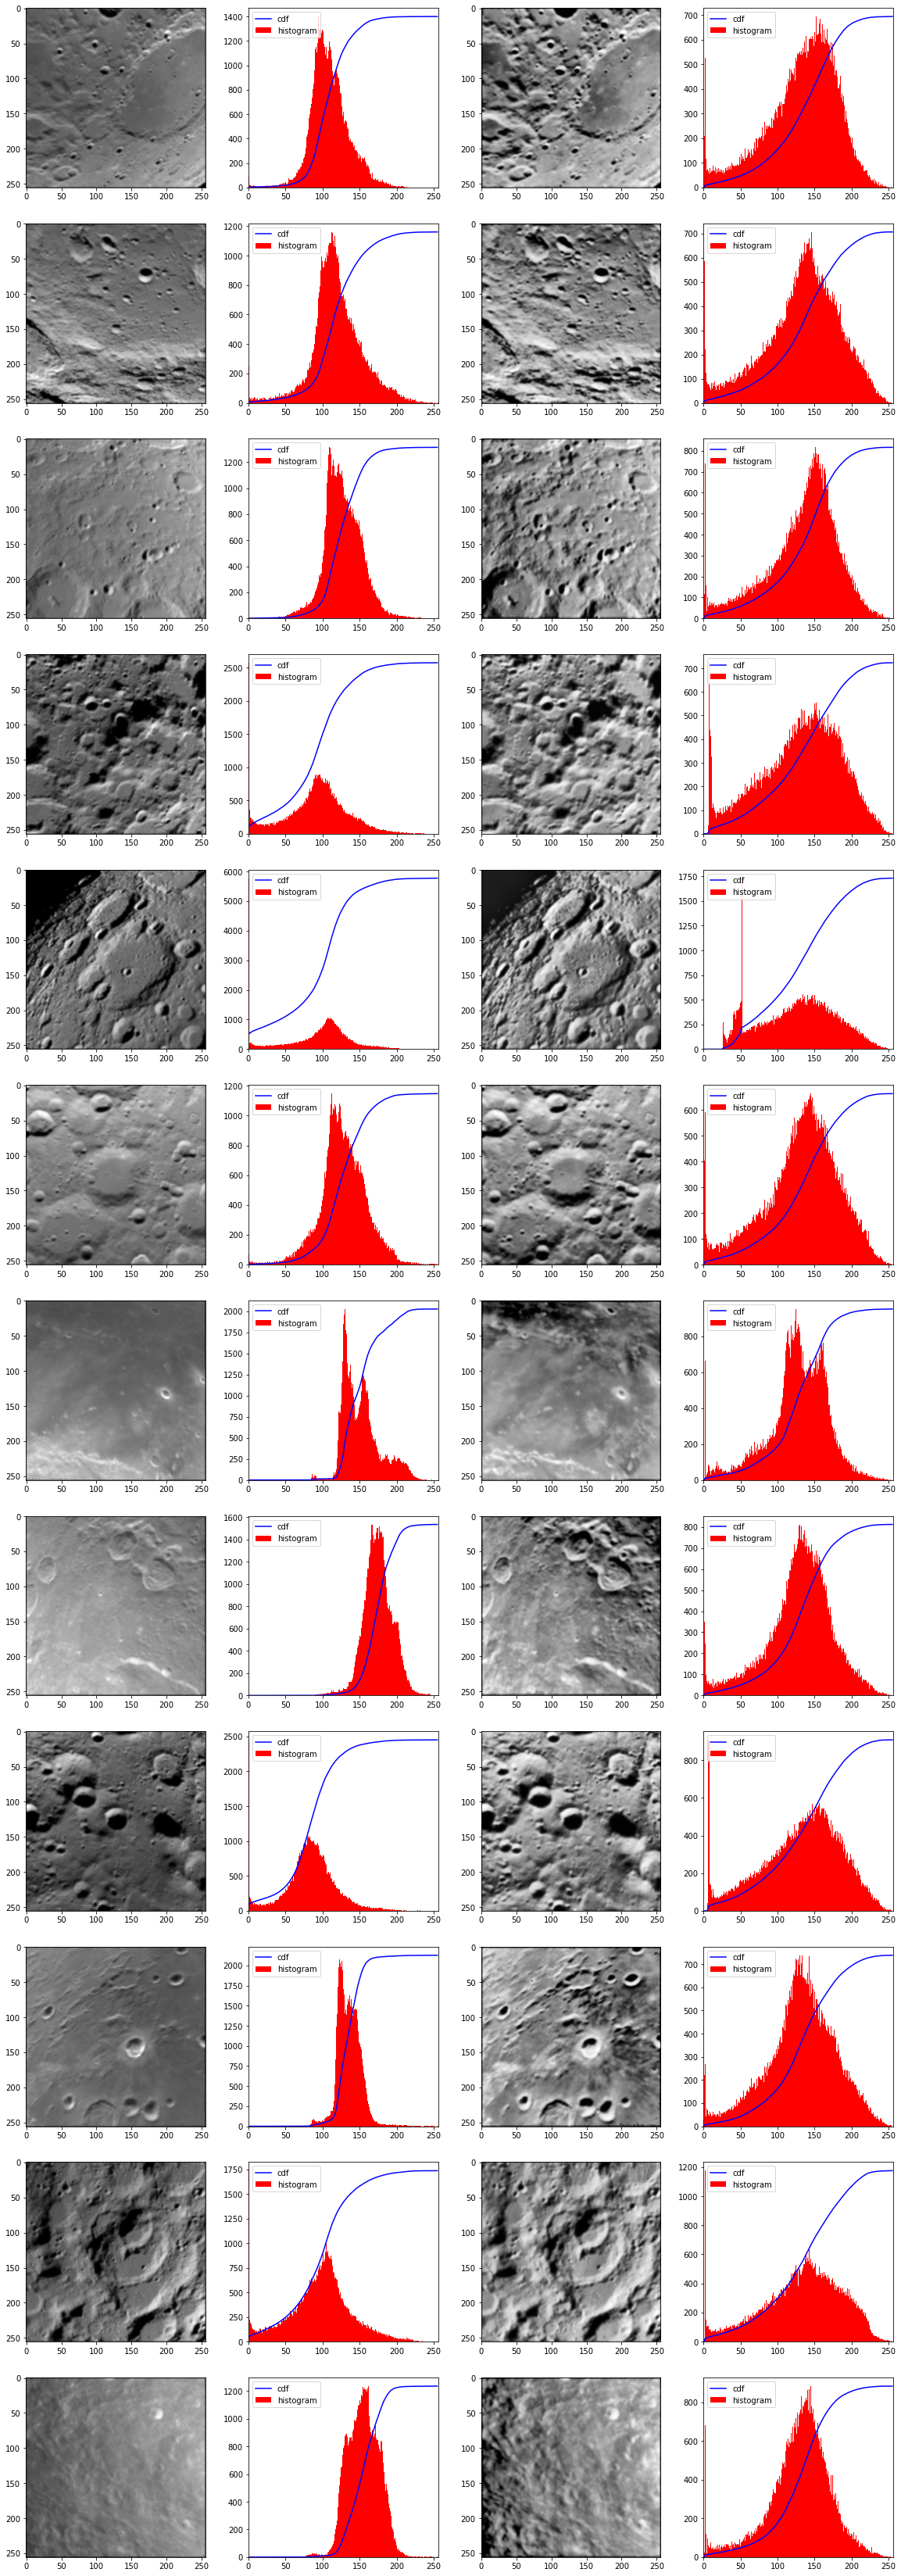

In [24]:
fig, axes = plt.subplots(n_demo, 4, figsize=(20, 5*n_demo))

for q in range(n_demo):
    i = np.random.randint(0, len(images)-1)

    axes[q, 0].imshow(images[i, 0], cmap='gray')

    hist, bins = np.histogram(images[i, 0].flatten(), 256, pixel_range)
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()
    axes[q, 1].plot(cdf_normalized, color = 'b')
    axes[q, 1].hist(images[i, 0].flatten(), 256, pixel_range, color='r')
    axes[q, 1].set_xlim(pixel_range)
    axes[q, 1].legend(('cdf','histogram'), loc = 'upper left')

    matched_img = match_histograms(images[i, 0], ref_cdf=ref_cdf)
    matched_img = cv2.GaussianBlur(matched_img, (3, 3), 1)
    matched_img = clahe.apply(matched_img.astype(np.uint8))
    axes[q, 2].imshow(matched_img, cmap='gray')

    hist, bins = np.histogram(matched_img.flatten(), 256, pixel_range)
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()
    axes[q, 3].plot(cdf_normalized, color = 'b')
    axes[q, 3].hist(matched_img.flatten(), 256, pixel_range, color = 'r')
    axes[q, 3].set_xlim(pixel_range)
    axes[q, 3].legend(('cdf','histogram'), loc = 'upper left')

In [14]:
%%time
matched_img = match_histograms(images[i, 0], ref_cdf=ref_cdf)

Wall time: 999 µs


array([0.02602347, 0.0280553 , 0.02965573, 0.03102162, 0.03223146,
       0.03333652, 0.03437106, 0.0353498 , 0.03629061, 0.03720117,
       0.03808943, 0.03897047, 0.03983796, 0.04069993, 0.04156128,
       0.04242215, 0.0432923 , 0.04416274, 0.04504523, 0.04593891,
       0.04684558, 0.04776543, 0.04870216, 0.04965695, 0.05063197,
       0.05163101, 0.05265708, 0.05370623, 0.05478486, 0.05589582,
       0.05703677, 0.05821203, 0.05942449, 0.0606847 , 0.06199292,
       0.06334596, 0.06475797, 0.06622524, 0.06775418, 0.06934455,
       0.07099756, 0.07271099, 0.0744837 , 0.07632793, 0.07822877,
       0.08019088, 0.08220766, 0.08427897, 0.08640794, 0.08860891,
       0.09089119, 0.09325929, 0.09572106, 0.09827351, 0.10092101,
       0.10366013, 0.10648694, 0.10937605, 0.11231733, 0.11532026,
       0.1183991 , 0.12154008, 0.12476295, 0.12805599, 0.13142523,
       0.13486191, 0.13835998, 0.14192815, 0.14556204, 0.14924931,
       0.15301488, 0.15686468, 0.16079435, 0.16479093, 0.16885